In [1]:
import pandas as pd
import numpy as np
import nltk
import huggingface_hub
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
nltk.download('omw-1.4')
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()
from bertopic import BERTopic
from umap import UMAP
import re as re
import os 
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from umap import UMAP

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/silvinhad/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/silvinhad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('/Users/silvinhad/Desktop/bertopic Python Analysis/Vera Magalhães/topics_tweets_veramagalhaes.csv').astype("string")
df.head(3)

,Document,Topic
0,sr deveria minimo decencia coragem bois trocad...,0
1,vera magalhaes pau mandada doria,0
2,sentiu vera magalhaes assustada quantidade gen...,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22437 entries, 0 to 22436
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Document  22437 non-null  string
 1   Topic     22437 non-null  string
dtypes: string(2)
memory usage: 350.7 KB


In [4]:
from transformers import pipeline

sentiment_model = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment",
    truncation=True,
    max_length=128
)

def analyze_sentiment(texts, batch_size=32):
    results = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        results.extend(
            sentiment_model(
                batch,
                truncation=True,
                max_length=128
            )
        )
    return results

sentiments = analyze_sentiment(df["Document"].tolist())


In [5]:
#sentiment analysis for each tweet
df["sentiment_label"] = [s["label"] for s in sentiments]
df["sentiment_score"] = [s["score"] for s in sentiments]

In [6]:
topic_sentiment = (
    df.groupby(["Topic", "sentiment_label"])
      .size()
      .unstack(fill_value=0)
      .reset_index()
)


In [7]:
sentiment_cols = topic_sentiment.columns.drop("Topic")

topic_sentiment_pct = topic_sentiment.copy()
topic_sentiment_pct[sentiment_cols] = (
    topic_sentiment_pct[sentiment_cols]
    .div(topic_sentiment_pct[sentiment_cols].sum(axis=1), axis=0)
)


In [8]:
# exporting sentiment analysis
topic_sentiment.to_csv(r'sentiment_topic_veramagalhaes.csv',index=False)


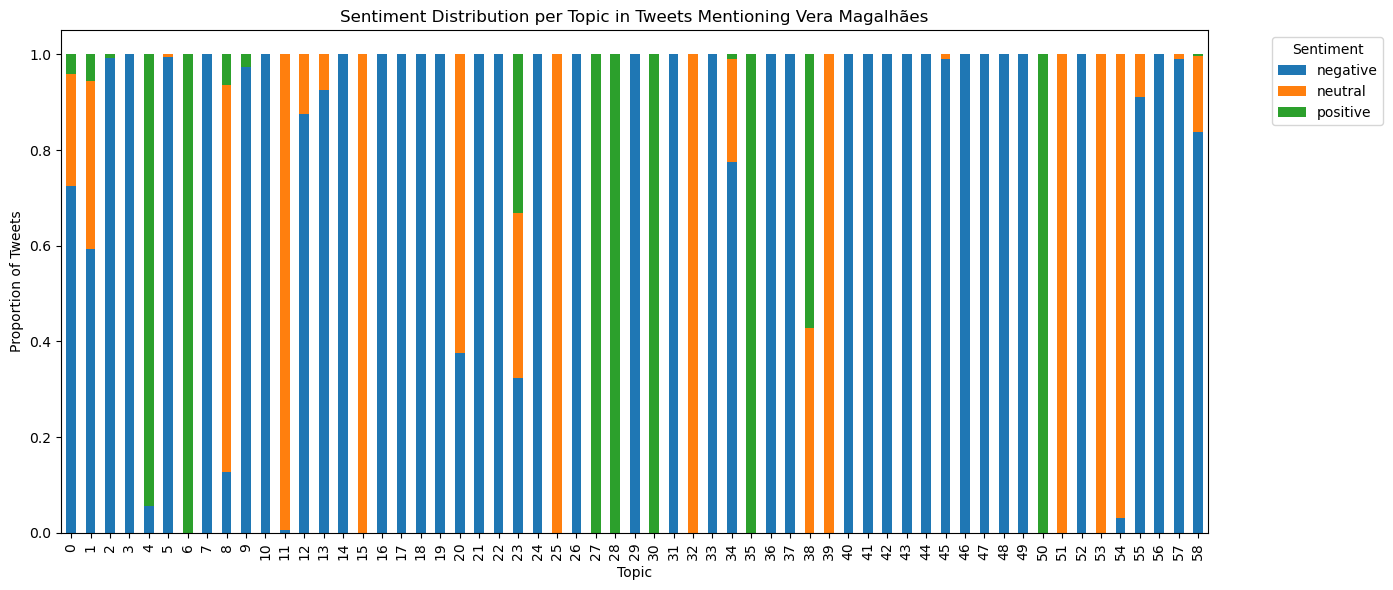

In [9]:
#Visualize
import matplotlib.pyplot as plt

topic_sentiment_pct.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 6)
)

plt.title("Sentiment Distribution per Topic in Tweets Mentioning Vera Magalhães")
plt.xlabel("Topic")
plt.ylabel("Proportion of Tweets")
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


In [10]:
sentiment_map = {
    "negative": -1,
    "neutral": 0,
    "positive": 1
}

df["sentiment_numeric"] = df["sentiment_label"].map(sentiment_map)


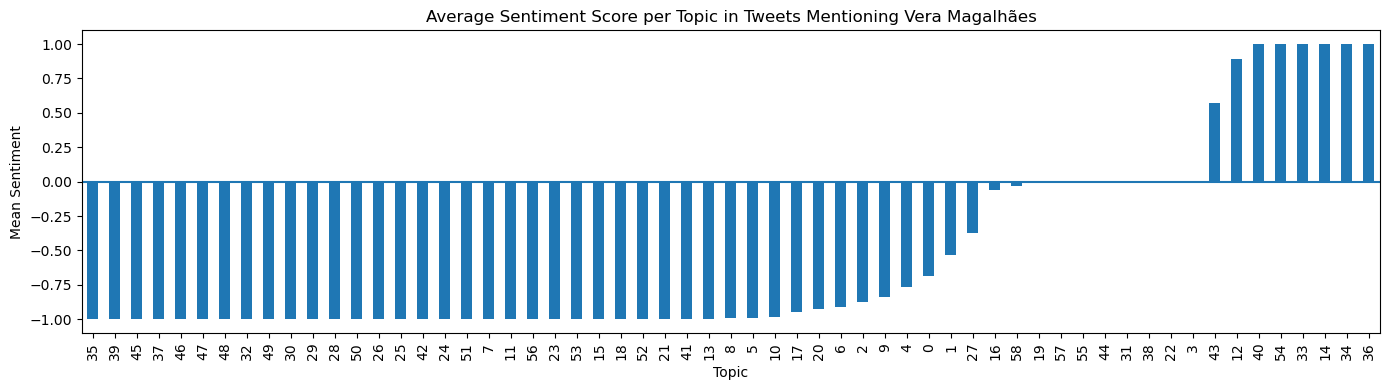

In [11]:
topic_sentiment_score = (
    df.groupby("Topic")["sentiment_numeric"]
      .mean()
      .sort_values()
)

topic_sentiment_score.plot(
    kind="bar",
    figsize=(14, 4)
)

plt.title("Average Sentiment Score per Topic in Tweets Mentioning Vera Magalhães")
plt.xlabel("Topic")
plt.ylabel("Mean Sentiment")
plt.axhline(0)  # neutral line
plt.tight_layout()
plt.show()

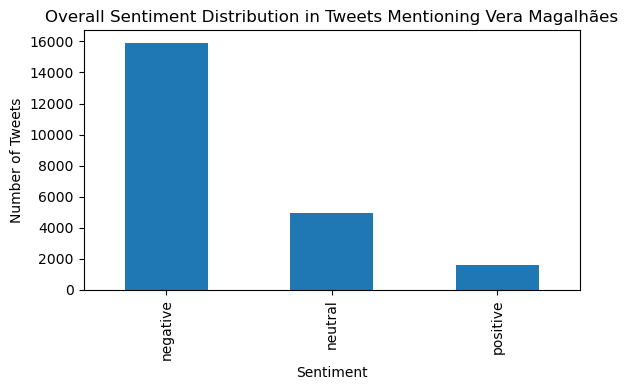

In [12]:
df["sentiment_label"].value_counts().plot(
    kind="bar",
    figsize=(6, 4)
)

plt.title("Overall Sentiment Distribution in Tweets Mentioning Vera Magalhães")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.show()
